# The Hodgkin-Huxley Model Neuron

The first time you open this notebook, follow the instructions below...

In [50]:
# Run only this first 'cell', when starting your notebook session.
# It will take ~3min
!curl -fsSL https://raw.githubusercontent.com/mgiugliano/PrinciplesCompNeurosciencesCourse/main/pvt/deploy_julia.sh | sh

# When the process is completed, perform a 'page refresh'.

LoadError: ignored

We numerically simulate the model proposed by Hodgkin and Huxley in the 1950s, describing the generation of the action potential in the giant axon of the squid. 


This model is characterised by four  state-variables (i.e. the membrane potential $V(t)$, the fraction of open potassium channels $n(t)$, and the fraction of open sodium channes - as described simultaneously by two additional state variables $m(t)$ and $h(t)$). 

All these variables evolve in time according to a system of *coupled* first-order ordinary differential equations, whose *external input* is the injected current (density) $I$ - here considered to be constant in time: 


$C \frac{dV(t)}{dt}\ = \ G_{leak} (E_{leak} - V) + G_{Na} m^3 h (E_{Na} - V) + G_{K} n^4 (E_{K} - V) + I$

$\frac{dn}{dt}\ = \ \alpha_n (1 - n) - \beta_n n$

$\frac{dm}{dt}\ = \ \alpha_m (1 - m) - \beta_m m$

$\frac{dh}{dt}\ = \ \alpha_h (1 - h) - \beta_h h$

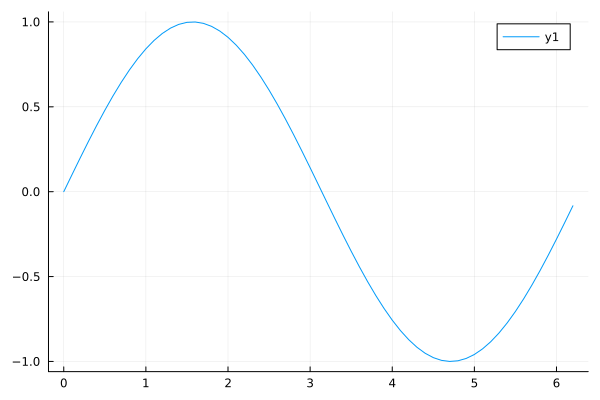

In [55]:
# Whatever follows the hash symbol is ignored and it is used to annotate or comment the code 

using Plots      # Tells the computer to “add” a package for (later) generating plots
gr()
x = 0:0.1:6.28
y = sin.(x)
plot(x, y)

We explore interactively what happens to the membrane potential for increasing values of the external current $I$ and how the model respond to two brief external current pulses, separated in time by a decreasing interval.

In [106]:
T      = 300.;    # Maximal lifetime of the simulation [ms]
Δt     = 0.01;    # Integration time step [ms] - WATCH OUT! DO NOT INCREASE!

C      = 0.010;   # This is the membrane (specific) capacitance [uF/mm^2]
gnamax = 1.2;     # Max (specific) sodium conductance [mS/mm^2]
gkmax  = 0.36;    # Max (specific) potassium conductance [mS/mm^2]
gl     = 0.003;   # Max (specific) leak conductance [mS/mm^2]

Ena    = 50.;     # Reversal potential for sodium currents [mV]
Ek     = -77.;    # Reversal potential for potassium currents [mV]
El     = -54.387; # Reversal potential for leak currents [mV]

time = 0:Δt:T;        # Array containg the "time" axis [ms]
N    = length(time);  # Length of "time", i.e. how many discrete time steps

In [3]:
function HH(I)
    W    = zeros(N,1)  # Array containing V as the time goes by
    Nspikes = 0        # Counter for the number of spikes 
    
    # Initial conditions:
    V      = El
    αm = 0.1 * (V+40.) / (1. - exp(-(V+40.)/10.))
    βm  = 4. * exp(-0.0556 * (V+65))

    αn = 0.01 * (V+55) / (1. - exp(-(V+55.)/10.))
    βn = 0.125 * exp(-(V+65.)/80.)

    αh = 0.07 * exp(-0.05*(V+65.))
    βh = 1. / (1. + exp(-0.1*(V+35.)))
    
    m      = αm / (αm + βm)
    h      = αh / (αh + βh) 
    n      = αn / (αn + βn) 
    
    tmp    = 0        # For the peak detection    
        
    # Euler method ---------------------------------------------------------------
    for k=1:N # Loop over each discrete step for time t
			
     # Kinetic rates are expressed in msec
     αm = 0.1 * (V + 40.) / (1. - exp(-(V + 40.) / 10.))
     βm  = 4. * exp(-0.0556 * (V + 65))

     αn = 0.01 * (V + 55) / (1. - exp(-(V + 55.)/10.))
     βn = 0.125 * exp(-(V + 65.) / 80.)

     αh = 0.07 * exp(-0.05*(V + 65.))
     βh = 1. / (1. + exp(-0.1*(V + 35.)))

     n     = n + Δt * (αn * (1-n) - βn * n)     # Euler forward method   
     m     = m + Δt * (αm * (1-m) - βm * m)     # Euler forward method  
     h     = h + Δt * (αh * (1-h) - βh * h)     # Euler forward method  

     Ina   = gnamax * m^3 * h * (Ena - V)       # By definition
     Ik    = gkmax  * n^4 * (Ek - V)			# By definition
     Ileak = gl     * (El - V)					# By definition
			
     V     = V + Δt/C * (Ina + Ik + Ileak + I)  # Euler forward method
            
     W[k]  = V; # Let's write the current V inside a new element of W[]
            
     if (tmp==0) && (V>-10)     # Detection of a "peak", with positive derivative
        tmp = 1;                
        Nspikes = Nspikes + 1;
     elseif (tmp==1) && (V<-10) # if negative derivative, ignore it
        tmp = 0;
     end #if
            
    end # for
    # ----------------------------------------------------------------------------

    freq = round(1000. * Nspikes / T) 
    
    return W, freq    
 end

HH (generic function with 1 method)

In [107]:
function HH2(Iext)
    N    = length(Iext)
    W    = zeros(N,1)  # Array containing V as the time goes by
    Nspikes = 0        # Counter for the number of spikes 
    
    # Initial conditions:
    V      = El
    αm = 0.1 * (V+40.) / (1. - exp(-(V+40.)/10.))
    βm  = 4. * exp(-0.0556 * (V+65))

    αn = 0.01 * (V+55) / (1. - exp(-(V+55.)/10.))
    βn = 0.125 * exp(-(V+65.)/80.)

    αh = 0.07 * exp(-0.05*(V+65.))
    βh = 1. / (1. + exp(-0.1*(V+35.)))
    
    m      = αm / (αm + βm)
    h      = αh / (αh + βh) 
    n      = αn / (αn + βn) 
    
    tmp    = 0        # For the peak detection    
        
    # Euler method ---------------------------------------------------------------
    for k=1:N # Loop over each discrete step for time t
			
     # Kinetic rates are expressed in msec
     αm = 0.1 * (V + 40.) / (1. - exp(-(V + 40.) / 10.))
     βm  = 4. * exp(-0.0556 * (V + 65))

     αn = 0.01 * (V + 55) / (1. - exp(-(V + 55.)/10.))
     βn = 0.125 * exp(-(V + 65.) / 80.)

     αh = 0.07 * exp(-0.05*(V + 65.))
     βh = 1. / (1. + exp(-0.1*(V + 35.)))

     n     = n + Δt * (αn * (1-n) - βn * n)     # Euler forward method   
     m     = m + Δt * (αm * (1-m) - βm * m)     # Euler forward method  
     h     = h + Δt * (αh * (1-h) - βh * h)     # Euler forward method  

     Ina   = gnamax * m^3 * h * (Ena - V)       # By definition
     Ik    = gkmax  * n^4 * (Ek - V)			# By definition
     Ileak = gl     * (El - V)					# By definition
			
     V     = V + Δt/C * (Ina + Ik + Ileak + Iext[k])  # Euler forward method
            
     W[k]  = V; # Let's write the current V inside a new element of W[]
            
     if (tmp==0) && (V>-10)     # Detection of a "peak", with positive derivative
        tmp = 1;                
        Nspikes = Nspikes + 1;
     elseif (tmp==1) && (V<-10) # if negative derivative, ignore it
        tmp = 0;
     end #if
            
    end # for
    # ----------------------------------------------------------------------------

    freq = round(1000. * Nspikes / T) 
    
    return W, freq    
 end

HH2 (generic function with 1 method)

In [108]:
function plot_all(xa, ya, xb, yb)
 # Plotting instructions ------------------------------------------------------		
  plot(xa, ya, 
      label="Numerical solution",
      linewidth=3, 
      linecolor=:black, 
      xtickfont=font(14, "Arial"),
      ytickfont=font(14, "Arial"),
      framestyle = :origin); # Numerical sol.

  plot!(xb, yb, 
      #label="Analytical solution (of a RC)", 
      linewidth=1, 
      linecolor=:blue, 
      title="Hodgkin-Huxley model", 
      xtickfont=font(14, "Arial"),
      ytickfont=font(14, "Arial"),
      leg = :true,
      framestyle = :origin); # Analytical sol.

  xlims!((0,150))
  ylims!((-130,30))
  xlabel!("time [ms]")                # Label for the horizontal axis
  ylabel!("Membrane potential [mV]")  # Label for the vertical axis
end

plot_all (generic function with 1 method)

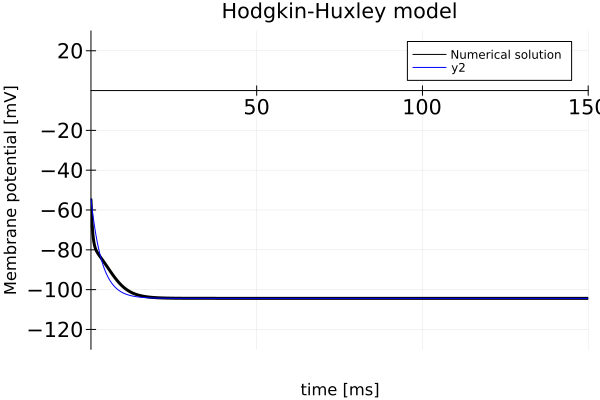

In [113]:
# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
I = -0.15 #@param {type:"slider", min:-0.18, max:1.5, step:0.01}


W, freq = HH(I)

Wanalyt = (-I/gl) * exp.(-time*gl/C) + (I/gl+El) * ones(N,1)

time = 0:Δt:T;        # Array containg the "time" axis [ms]

plot_all(time, W, time, Wanalyt)

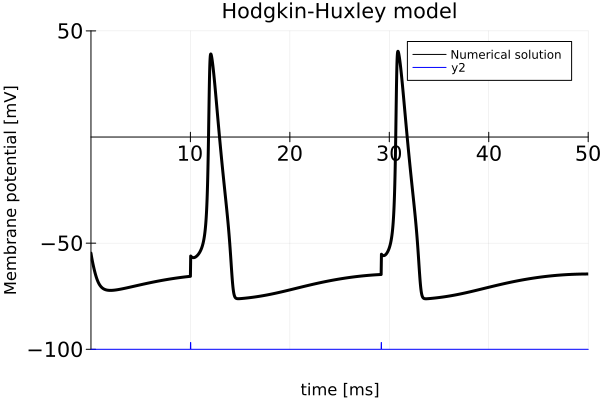

In [116]:
# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
T = 50.
I0 = 3.2 #@param {type:"slider", min:0, max:20, step:0.05}
I1 = 3.2 #@param {type:"slider", min:0, max:20, step:0.05}
T0 = 19.14 #@param {type:"slider", min:0.01, max:50, step:0.01}

delay = 10.

i1 = 0:Δt:delay
i2 = (i1[end] + Δt):Δt:(i1[end] + Δt + 2*Δt)
i3 = (i2[end] + Δt):Δt:(i2[end] + Δt + T0)
i4 = (i3[end] + Δt):Δt:(i3[end] + Δt + 2*Δt)
i5 = (i4[end] + Δt):Δt:T

M1 = length(i1)
M2 = length(i2)
M3 = length(i3)
M4 = length(i4)
M5 = length(i5)

Iext = [zeros(M1,1); I0 .* ones(M2,1); zeros(M3,1); I1 .* ones(M4,1); zeros(M5,1)]
length(Iext)

W2 = HH2(Iext)
time = 0:Δt:T;        # Array containg the "time" axis [ms]
plot_all(time, W2, time, Iext.-100)

xlims!((0,50))
ylims!((-100,50))